<a href="https://colab.research.google.com/github/akash-sureshkumar/Gold_sales_dashboard/blob/main/gold_ml_advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here is the dataset:
         Date        Product  Units_Sold
0  2023-01-01      Gold Ring          91
1  2023-01-01     Gold Chain          41
2  2023-01-01      Gold Coin          41
3  2023-01-01    Gold Bangle          30
4  2023-01-01  Gold Necklace          99

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525 entries, 0 to 524
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        525 non-null    object
 1   Product     525 non-null    object
 2   Units_Sold  525 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 12.4+ KB
None


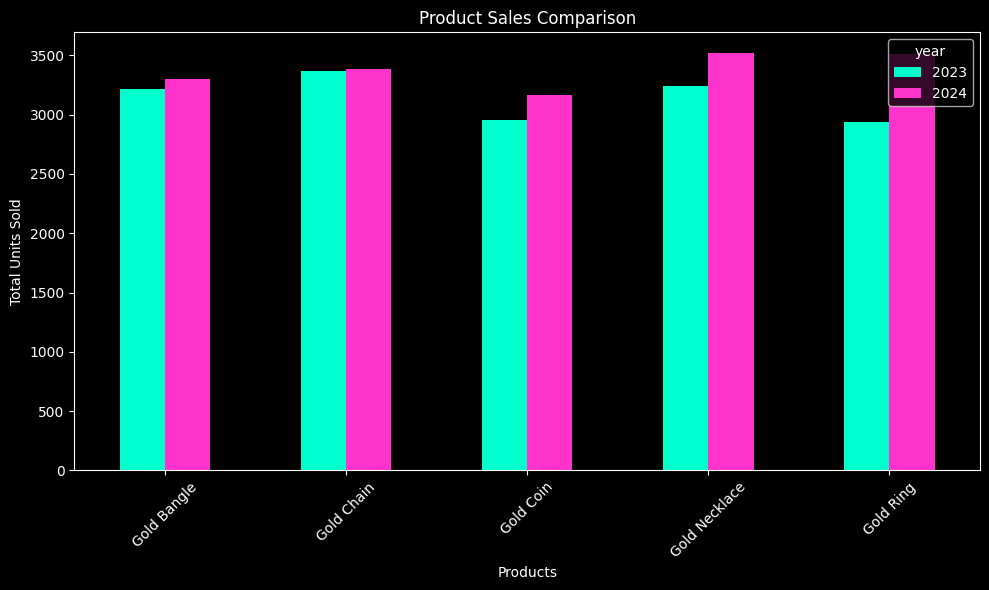

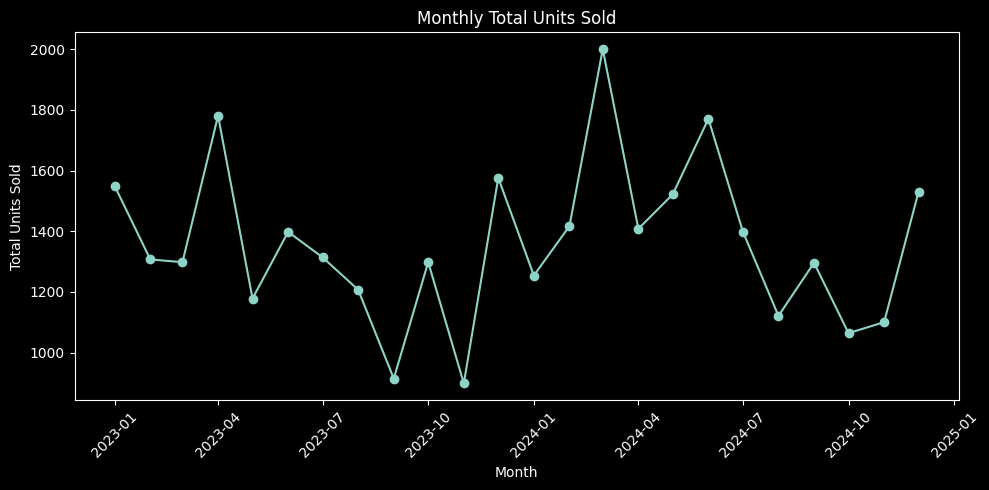

LinearRegression Mean Squared Error: 121944.53367189897
XGBoost Mean Squared Error: 61336.21875
       Month  Predicted_Sales
0 2025-01-31       1399.00061
1 2025-02-28       1399.00061
2 2025-03-31       1399.00061


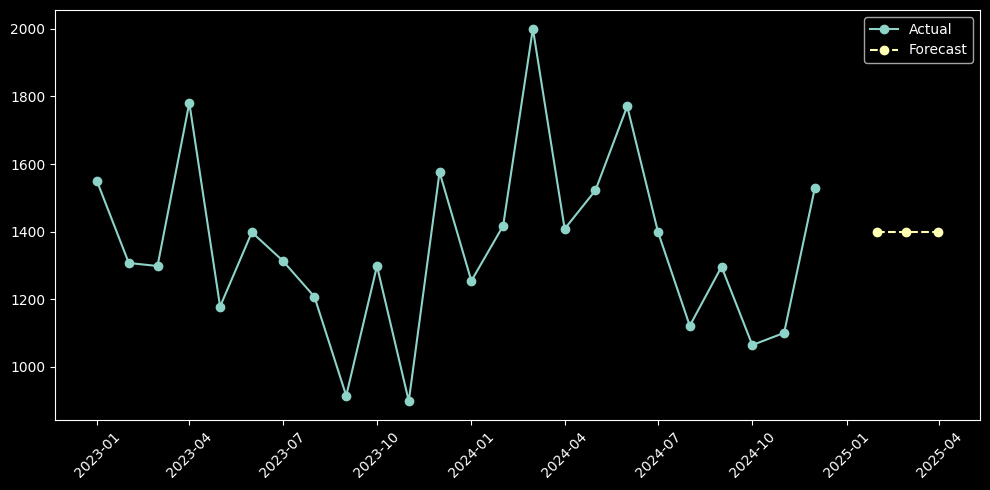

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost  import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import joblib
import plotly.express as px


df = pd.read_csv('https://raw.githubusercontent.com/akash-sureshkumar/Gold_sales_dashboard/5174013e5d480cfbeb07a371cd073065aa2e5257/gold_sales_2023_2024.csv')

print("Here is the dataset:")
print(df.head())
print("\nInfo:")
print(df.info())

df['date'] = pd.to_datetime(df['Date'])
df['year'] = df['date'].dt.year
df['Month'] = df['date'].dt.to_period('M').dt.to_timestamp()


product_summary = df.groupby(['Product', 'year'])['Units_Sold'].sum().reset_index()
product_pivot = product_summary.pivot(index='Product', columns='year', values='Units_Sold').fillna(0)

plt.style.use('dark_background')
product_pivot.plot(kind='bar', figsize=(10,6), color=['#00ffcc', '#ff33cc'])
plt.title("Product Sales Comparison")
plt.xlabel("Products")
plt.ylabel("Total Units Sold")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.savefig("product sales comparison matplotlib_png") #
plt.show()

fig = px.line_polar(product_summary,
                    theta='Product',
                    r='Units_Sold',
                    line_close=True,
                    color='year',
                    color_discrete_sequence=px.colors.qualitative.Pastel,
                    template='plotly_dark',
                    title='Product Sales Comparison')
fig.show()


monthly_total=df.groupby('Month')['Units_Sold'].sum().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(monthly_total['Month'], monthly_total['Units_Sold'], marker='o',)
plt.xlabel('Month')
plt.ylabel('Total Units Sold')
plt.title('Monthly Total Units Sold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


monthly_total['Month_Num'] = np.arange(1, len(monthly_total) + 1)
x=monthly_total[['Month_Num']]
y=monthly_total['Units_Sold']
split=int(0.8*len(x))
x_train,x_test=x[:split],x[split:]
y_train,y_test=y[:split],y[split:]

lr=LinearRegression()
lr.fit(x_train,y_train)
y_pred_lr=lr.predict(x_test)
mse_lr=mean_squared_error(y_test,y_pred_lr)
print('LinearRegression Mean Squared Error:',mse_lr)


xgb=XGBRegressor()
xgb.fit(x_train,y_train)
y_pred_xgb=xgb.predict(x_test)
mse_xgb=mean_squared_error(y_test,y_pred_xgb)
print('XGBoost Mean Squared Error:',mse_xgb)


future_nums = np.array([[len(x)+i] for i in range(1,4)])
future_preds = xgb.predict(future_nums)
future_months = pd.date_range(start=monthly_total['Month'].max() + pd.offsets.MonthBegin(), periods=3, freq='ME')
df_forecast = pd.DataFrame({'Month': future_months, 'Predicted_Sales': future_preds})
print(df_forecast)


plt.figure(figsize=(10, 5))
plt.plot(monthly_total['Month'], monthly_total['Units_Sold'], marker='o', label='Actual')
plt.plot(df_forecast['Month'], df_forecast['Predicted_Sales'], label='Forecast', linestyle='--', marker='o')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

joblib.dump(xgb,'total_sales_xgb_model.joblib')


def train_and_predict_product_sales(df, product_name, periods=6*30):
    """Trains an XGBoost model for a specific product and predicts future sales."""
    product_df = df[df['Product'] == product_name].copy()
    product_df['Date'] = pd.to_datetime(product_df['Date'])
    product_df = product_df.sort_values(by='Date')

    product_df['Year'] = product_df['Date'].dt.year
    product_df['Month'] = product_df['Date'].dt.month
    product_df['Day'] = product_df['Date'].dt.day

    X = product_df[['Year', 'Month', 'Day']]
    y = product_df['Units_Sold']

    xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)
    xgb_model.fit(X, y)

    last_date = product_df['Date'].max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=periods, freq='D')
    future_df = pd.DataFrame({'Date': future_dates})
    future_df['Year'] = future_df['Date'].dt.year
    future_df['Month'] = future_df['Date'].dt.month
    future_df['Day'] = future_df['Date'].dt.day
    X_future = future_df[['Year', 'Month', 'Day']]
    future_predictions = xgb_model.predict(X_future)
    predictions_df = future_df.copy()
    predictions_df['Predicted_Units_Sold'] = future_predictions

    return product_df, predictions_df, xgb_model


def plot_product_sales_forecast(product_df, predictions_df, product_name):
    """Visualizes historical and predicted sales using Plotly Express."""
    fig = px.line(product_df, x='Date', y='Units_Sold', title=f' 6-Month Prediction for {product_name}')
    fig.add_scatter(x=predictions_df['Date'], y=predictions_df['Predicted_Units_Sold'], mode='lines', name='Predicted Sales')
    fig.update_layout(
        title=f' 6-Month Prediction for {product_name} sales',
        xaxis_title='Date',
        yaxis_title='Units Sold',
        showlegend=True,
        template='plotly_dark'
    )
    fig.show()


products = df['Product'].unique()
for product in products:
    product_df, predictions_df, product_model = train_and_predict_product_sales(df, product)
    plot_product_sales_forecast(product_df, predictions_df, product)

df.to_csv("cleaned gold datasets", index=False)